In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
import os
import time


from scikeras.wrappers import KerasClassifier
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV

2022-06-27 13:12:46.897497: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

In [4]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train_full = np.r_[X_train, X_val]
y_train_full = np.r_[y_train, y_val]

In [5]:
y_train.shape

(55000,)

In [6]:
def build_model(input_shape=784, output_shape=10, n_hidden=3, n_neurons=200, learning_rate=1e-3, compile=True):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(output_shape, activation="softmax"))
                  
    if compile:
        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
            metrics=["accuracy"],
        )
    
    return model

In [7]:
def get_tensorboard_cb():
    base_dir = os.path.join(os.curdir, ".tflogs")
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return keras.callbacks.TensorBoard(run_dir)    

In [8]:
model = build_model(learning_rate=1e-5)

2022-06-27 13:12:49.019121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 13:12:49.435186: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-27 13:12:49.435223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 10)                2010      
                                                                 
Total params: 239,410
Trainable params: 239,410
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers

In [11]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

In [12]:
n_steps = 500

checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_digits_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = get_tensorboard_cb()
learning_rate_callback = LearningRateCallback(1e-5, 1e1, n_steps)

history = model.fit(
    X_train,
    y_train,
    epochs=1,
    steps_per_epoch=n_steps,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb, learning_rate_callback],
)

 33/500 [>.............................] - ETA: 2s - loss: 2.3137 - accuracy: 0.0945

2022-06-27 13:12:50.500216: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


500/500 [==============================] - 4s 7ms/step - loss: nan - accuracy: 0.2903 - val_loss: nan - val_accuracy: 0.1018


approximate best learning rate: 0.08392840226491292


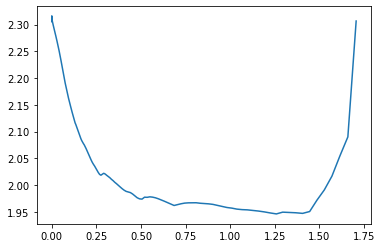

In [13]:
learning_rates = np.array(learning_rate_callback.learning_rates)
losses = np.array(learning_rate_callback.losses)

idx = losses < 10
learning_rates_clean = learning_rates[idx]
losses_clean = losses[idx]

plt.plot(learning_rates_clean, losses_clean)
best_idx = np.argmin(losses_clean)
best_learning_rate = learning_rates[best_idx] / 15.
print(f"approximate best learning rate: {best_learning_rate}")

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
model = build_model(learning_rate=best_learning_rate)

model_file = "mnist_digits_model.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
tensorboard_cb = get_tensorboard_cb()

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2898 - accuracy: 0.9113 - val_loss: 0.1227 - val_accuracy: 0.9596
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1086 - accuracy: 0.9669 - val_loss: 0.0986 - val_accuracy: 0.9674
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0735 - accuracy: 0.9768 - val_loss: 0.0903 - val_accuracy: 0.9720
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0552 - accuracy: 0.9823 - val_loss: 0.0750 - val_accuracy: 0.9768
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0416 - accuracy: 0.9870 - val_loss: 0.0597 - val_accuracy: 0.9812
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0836 - val_accuracy: 0.9750
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0884 - val_ac

In [16]:
model = keras.models.load_model(model_file)
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0757 - accuracy: 0.9781


[0.07571646571159363, 0.9781000018119812]

### Bayesian Optimization Using skopt BayesSearchCV

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

clf = KerasClassifier(
    model=build_model,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD,
    callbacks=[early_stopping_cb],
    epochs=10,
    n_hidden=3,
    n_neurons=200,
    learning_rate=1e-3,
    compile=False,
)

opt = BayesSearchCV(
    clf,
    {
        "n_hidden": (1, 5),
        "n_neurons": (20, 300),
        "optimizer__learning_rate": (1e-3, 1., "uniform")
    },
    n_iter=32,
    cv=3,
    n_jobs=16,
)

opt.fit(X_train_full, y_train_full)

2022-06-27 13:16:35.076588: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:16:35.076590: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:16:35.081094: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:16:36.388277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:16:37.947612: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:16:37.985352: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:16:38.018353: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 2.1362 - accuracy: 0.2352
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.1027
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 6/10
1250/12

2022-06-27 13:17:32.976966: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:17:32.978976: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:17:32.979523: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:17:34.269762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:17:35.841996: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:17:35.897932: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:17:35.906658: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 5ms/step - loss: 0.3384 - accuracy: 0.8968
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3497 - accuracy: 0.8934
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1299 - accuracy: 0.9610
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1282 - accuracy: 0.9629
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0932 - accuracy: 0.9729
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0684 - accuracy: 0.9787
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0694 - accuracy: 0.9791
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0722 - accuracy: 0.9779
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0515 - accuracy: 0.9837
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0532 - accuracy

2022-06-27 13:18:34.980356: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:18:34.980356: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:18:34.980356: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:18:36.292655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:18:37.940152: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:18:37.950826: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:18:37.975567: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.3007 - accuracy: 0.9081
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.3131 - accuracy: 0.9035
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1142 - accuracy: 0.9647
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1185 - accuracy: 0.9637
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1180 - accuracy: 0.9638
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0774 - accuracy: 0.9757
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0556 - accuracy: 0.9818
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0576 - accuracy: 0.9823
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0555 - accuracy: 0.9822
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0376 - accuracy

2022-06-27 13:19:33.947584: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:19:33.947584: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:19:33.947584: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:19:35.262366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:19:36.906478: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:19:36.912878: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:19:36.966432: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.6822 - accuracy: 0.7821
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.8511 - accuracy: 0.7071
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2795 - accuracy: 0.9238
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2907 - accuracy: 0.9220
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2201 - accuracy: 0.9419
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2439 - accuracy: 0.9367
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2774 - accuracy: 0.9307
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1900 - accuracy: 0.9497
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2123 - accuracy: 0.9434
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2378 - accuracy

2022-06-27 13:20:33.001000: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:20:33.001000: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:20:33.014559: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:20:34.303272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:20:35.923937: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:20:35.953244: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:20:35.987505: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.5826 - accuracy: 0.8161
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.5773 - accuracy: 0.8248
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.7728 - accuracy: 0.7512
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2009 - accuracy: 0.9445
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2289 - accuracy: 0.9367
Epoch 3/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2071 - accuracy: 0.9436
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1521 - accuracy: 0.9570
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1653 - accuracy: 0.9540
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1246 - accuracy: 0.9647
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1304 - accuracy

2022-06-27 13:21:33.253510: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


 335/1250 [=======>......................] - ETA: 3s - loss: 0.6147 - accuracy: 0.8044

2022-06-27 13:21:34.579669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 448/1250 [=========>....................] - ETA: 2s - loss: 0.5302 - accuracy: 0.8325

2022-06-27 13:21:35.093917: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-27 13:21:35.093970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6319 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


  15/1250 [..............................] - ETA: 4s - loss: 2.0245 - accuracy: 0.3250   

2022-06-27 13:21:36.269850: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 5s 4ms/step - loss: 0.3140 - accuracy: 0.9016
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.3058 - accuracy: 0.9051
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1236 - accuracy: 0.9630
Epoch 3/10
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1168 - accuracy: 0.9640
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0792 - accuracy: 0.9755
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0778 - accuracy: 0.9769
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0581 - accuracy: 0.9815
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0591 - accuracy: 0.9814
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0430 - accuracy: 0.9859
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0468

2022-06-27 13:27:19.225940: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/10
Epoch 1/10
 453/1250 [=========>....................] - ETA: 2s - loss: 0.4617 - accuracy: 0.8579

2022-06-27 13:27:20.564934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 596/1250 [=============>................] - ETA: 1s - loss: 0.4084 - accuracy: 0.8753

2022-06-27 13:27:21.048458: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-27 13:27:21.048496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5295 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


 946/1250 [=====================>........] - ETA: 0s - loss: 0.3327 - accuracy: 0.8984

2022-06-27 13:27:22.130566: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.2871 - accuracy: 0.9117
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1296 - accuracy: 0.9603
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1250 - accuracy: 0.9616
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0938 - accuracy: 0.9707
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0862 - accuracy: 0.9733
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0899 - accuracy: 0.9723
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0763 - accuracy: 0.9756
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0673 - accuracy: 0.9790
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0582 - accuracy: 0.9811
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0526 - accuracy

/home/jon/anaconda3/envs/hands-on/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/10
Epoch 1/10
Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0055 - accuracy: 0.2916
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3033 - accuracy: 0.1082
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0185 - accuracy: 0.2534
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3064 - accuracy: 0.1050
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3064 - accuracy: 0.1066
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3068 - accuracy: 0.1036
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3063 - accuracy: 0.1076
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3062 - accuracy: 0.1061
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3069 - accuracy: 0.1023
Epoch 5/10
1250/1250 [==============================] - 6s 5

2022-06-27 13:36:27.531520: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:36:27.591014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:36:27.591014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:36:28.832132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:36:30.446450: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:36:30.448579: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:36:30.480289: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 7s 5ms/step - loss: 0.4132 - accuracy: 0.8749
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.4434 - accuracy: 0.8652
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.4345 - accuracy: 0.8662
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1476 - accuracy: 0.9575
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1485 - accuracy: 0.9578
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1498 - accuracy: 0.9579
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1043 - accuracy: 0.9697
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1013 - accuracy: 0.9706
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0805 - accuracy: 0.9758
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0783 - accuracy

2022-06-27 13:37:32.474161: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:37:32.474160: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/10
 398/1250 [========>.....................] - ETA: 2s - loss: 2.1686 - accuracy: 0.3177

2022-06-27 13:37:33.796002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 13:37:33.828114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 530/1250 [===========>..................] - ETA: 2s - loss: 2.1044 - accuracy: 0.3848

2022-06-27 13:37:34.252445: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-27 13:37:34.252485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16111 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6
2022-06-27 13:37:34.275322: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-27 13:37:34.275362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16099 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


   1/1250 [..............................] - ETA: 17:28 - loss: 2.3499 - accuracy: 0.1250

2022-06-27 13:37:35.358488: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:37:35.383421: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 4s 3ms/step - loss: 1.7551 - accuracy: 0.5764
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7473 - accuracy: 0.5961
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7578 - accuracy: 0.5838
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8671 - accuracy: 0.8215
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8765 - accuracy: 0.8227
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8674 - accuracy: 0.8181
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5799 - accuracy: 0.8611
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5818 - accuracy: 0.8606
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5761 - accuracy: 0.8571
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4722 - accuracy

2022-06-27 13:38:29.069138: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:38:29.069138: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:38:29.069137: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:38:30.365924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:38:31.960102: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:38:32.004364: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:38:32.059145: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.4107 - accuracy: 0.8744
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.4630 - accuracy: 0.8581
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.3985 - accuracy: 0.8769
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1540 - accuracy: 0.9547
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1559 - accuracy: 0.9555
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1165 - accuracy: 0.9657
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1095 - accuracy: 0.9683
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0863 - accuracy: 0.9736
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0852 - accuracy: 0.9749
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0882 - accuracy

2022-06-27 13:39:28.942715: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:39:28.942715: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:39:28.942716: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:39:30.238816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:39:31.810735: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:39:31.826804: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:39:31.847717: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.2473 - accuracy: 0.9248
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2487 - accuracy: 0.9244
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2499 - accuracy: 0.9237
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1046 - accuracy: 0.9681
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1024 - accuracy: 0.9690
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1058 - accuracy: 0.9679
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0672 - accuracy: 0.9792
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0705 - accuracy: 0.9785
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0485 - accuracy: 0.9847
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0503 - accuracy

2022-06-27 13:40:23.335989: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:40:23.335990: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:40:23.344131: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 13:40:24.625554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/10
Epoch 1/10
Epoch 1/10


2022-06-27 13:40:26.254847: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:40:26.265103: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-27 13:40:26.274550: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 7s 5ms/step - loss: 0.3964 - accuracy: 0.8766
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.3945 - accuracy: 0.8801
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1473 - accuracy: 0.9571
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1500 - accuracy: 0.9558
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1511 - accuracy: 0.9552
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1059 - accuracy: 0.9684
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1058 - accuracy: 0.9693
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0819 - accuracy: 0.9754
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0851 - accuracy: 0.9745
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0642 - accuracy

2022-06-27 13:41:27.034224: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


 462/1250 [==========>...................] - ETA: 2s - loss: 0.5338 - accuracy: 0.8461

2022-06-27 13:41:28.374263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 608/1250 [=============>................] - ETA: 1s - loss: 0.4885 - accuracy: 0.8588

2022-06-27 13:41:28.887614: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-27 13:41:28.887649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6049 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


  34/1250 [..............................] - ETA: 3s - loss: 1.5651 - accuracy: 0.5423 

2022-06-27 13:41:29.998675: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 4s 3ms/step - loss: 0.3877 - accuracy: 0.8874
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3920 - accuracy: 0.8862
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2320 - accuracy: 0.9324
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2431 - accuracy: 0.9282
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2367 - accuracy: 0.9315
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1916 - accuracy: 0.9419
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2057 - accuracy: 0.9395
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1998 - accuracy: 0.9430
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1653 - accuracy: 0.9506
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1825 - accuracy

BayesSearchCV(cv=3,
              estimator=KerasClassifier(callbacks=[<keras.callbacks.EarlyStopping object at 0x7f373d653640>], compile=False, epochs=10, learning_rate=0.001, loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function build_model at 0x7f3740e179a0>, n_hidden=3, n_neurons=200, optimizer=<class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>),
              n_iter=32, n_jobs=16,
              search_spaces={'n_hidden': (1, 5), 'n_neurons': (20, 300),
                             'optimizer__learning_rate': (0.001, 1.0,
                                                          'uniform')})

In [18]:
print(opt.best_params_)
print(opt.best_score_)
best_params = opt.best_estimator_.get_params()
best_params.update({'epochs': 50})
print(best_params)
best_clf = KerasClassifier(**best_params)

OrderedDict([('n_hidden', 1), ('n_neurons', 300), ('optimizer__learning_rate', 0.3749868952421413)])
0.9788666666666667
{'model': <function build_model at 0x7f3740e179a0>, 'build_fn': None, 'warm_start': False, 'random_state': None, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, 'loss': 'sparse_categorical_crossentropy', 'metrics': ['accuracy'], 'batch_size': None, 'validation_batch_size': None, 'verbose': 1, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f373d840760>], 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 50, 'n_hidden': 1, 'n_neurons': 300, 'learning_rate': 0.001, 'compile': False, 'optimizer__learning_rate': 0.3749868952421413, 'class_weight': None}


In [19]:
best_clf.fit(X_train_full, y_train_full)

Epoch 1/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2059 - accuracy: 0.9367
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0865 - accuracy: 0.9738
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0588 - accuracy: 0.9811
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0406 - accuracy: 0.9870
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0314 - accuracy: 0.9899
Epoch 6/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0217 - accuracy: 0.9934
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0159 - accuracy: 0.9949
Epoch 8/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0122 - accuracy: 0.9961
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0078 - accuracy: 0.9980
Epoch 10/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.004

KerasClassifier(
	model=<function build_model at 0x7f3740e179a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>
	loss=sparse_categorical_crossentropy
	metrics=['accuracy']
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f373d840760>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	n_hidden=1
	n_neurons=300
	learning_rate=0.001
	compile=False
	optimizer__learning_rate=0.3749868952421413
	class_weight=None
)

In [20]:
best_clf.score(X_test, y_test)

313/313 [==============================] - 1s 3ms/step


0.9857

It seems that the best score is found by a single layer with the maximum number of neurons specified in the search space. This suggests that it might be a good idea to expand the search space into more neurons per layer. For the purposes of this exercise I'll stop here, as my main goal was to learn how to use a keras model with bayesian optimizer.